In [1]:
import os
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import random
from torch.utils.data import Dataset, DataLoader
from pycocotools.coco import COCO
import numpy as np
from PIL import Image
import torchvision.transforms.functional as TF 
from tqdm import tqdm

class COCOSegmentationDataset(Dataset):
    def __init__(self, root_dir, ann_file, transform=None, target_classes=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            ann_file (string): Path to the json annotation file.
            transform (callable, optional): Optional transform to be applied
                on a sample.
            target_classes (list, optional): List of class names to include. 
                If None, loads all classes.
        """
        self.root_dir = root_dir
        self.coco = COCO(ann_file)
        self.transform = transform
        
        # Filter for specific classes if requested
        if target_classes:
            self.cat_ids = self.coco.getCatIds(catNms=target_classes)
            # Get all image IDs that contain at least one of the target categories
            self.ids = []
            for cat_id in self.cat_ids:
                self.ids.extend(self.coco.getImgIds(catIds=[cat_id]))
            self.ids = list(set(self.ids)) # Remove duplicates
        else:
            self.cat_ids = self.coco.getCatIds()
            self.ids = list(self.coco.imgs.keys())

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, index):
        coco = self.coco
        img_id = self.ids[index]
        
        # 1. Load Image
        img_info = coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.root_dir, img_info['file_name'])
        image = Image.open(img_path).convert('RGB')
        
        # 2. Generate Mask (Semantic Segmentation)
        # U-Net expects a label for each pixel[cite: 22].
        # COCO stores annotations as polygons. We must rasterize them.
        ann_ids = coco.getAnnIds(imgIds=img_id, catIds=self.cat_ids)
        anns = coco.loadAnns(ann_ids)
        
        # Create an empty mask
        mask = np.zeros((img_info['height'], img_info['width']), dtype=np.uint8)
        
        for ann in anns:
            # Determine the class ID (map COCO category ID to a continuous range if needed)
            # Here we just use the polygon to draw on the mask
            pixel_value = ann['category_id'] 
            
            # pycocotools provides a method to convert annotation to binary mask
            ann_mask = coco.annToMask(ann)
            
            # Combine masks (taking max ensures overlapping objects don't zero out)
            mask = np.maximum(mask, ann_mask * pixel_value)

        # Convert to PIL for consistent transformations
        mask = Image.fromarray(mask)

        # 3. Apply Transformations
        # The paper uses 572x572 inputs[cite: 27], but 512x512 is standard for modern GPUs.
        if self.transform:
            # Note: You need a transform pipeline that applies the same random 
            # geometric transforms (crop, resize, rotate) to BOTH image and mask 
            # to keep them aligned. 
            image, mask = self.transform(image, mask)

        return image, mask

# Example Usage
if __name__ == "__main__":
    
    def simple_transform(image, mask):
        # Resize to a power of 2 (e.g., 256x256 or 512x512)
        # The original paper used unpadded convolutions resulting in output shrinkage.
        # Modern implementations often use padding, but resizing is still required.
        image = TF.resize(image, (256, 256))
        mask = TF.resize(mask, (256, 256), interpolation=Image.NEAREST) # Nearest for masks to keep class IDs
        
        image = TF.to_tensor(image)
        mask = torch.as_tensor(np.array(mask), dtype=torch.long)
        return image, mask

    # Initialize Dataset
    # Replace paths with your actual COCO paths
    data_path = './coco/train2017' 
    ann_path = './coco/annotations/instances_train2017.json'
    
    # Let's filter for just 'person' to make a human-segmentation U-Net
    dataset = COCOSegmentationDataset(
        root_dir=data_path, 
        ann_file=ann_path, 
        transform=simple_transform,
        target_classes=['person']
    )

    dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

    # Test the loader
    images, masks = next(iter(dataloader))
    print(f"Image Batch Shape: {images.shape}") # Should be [4, 3, 256, 256]
    print(f"Mask Batch Shape: {masks.shape}")   # Should be [4, 256, 256]

loading annotations into memory...
Done (t=15.64s)
creating index...
index created!
Image Batch Shape: torch.Size([4, 3, 256, 256])
Mask Batch Shape: torch.Size([4, 256, 256])


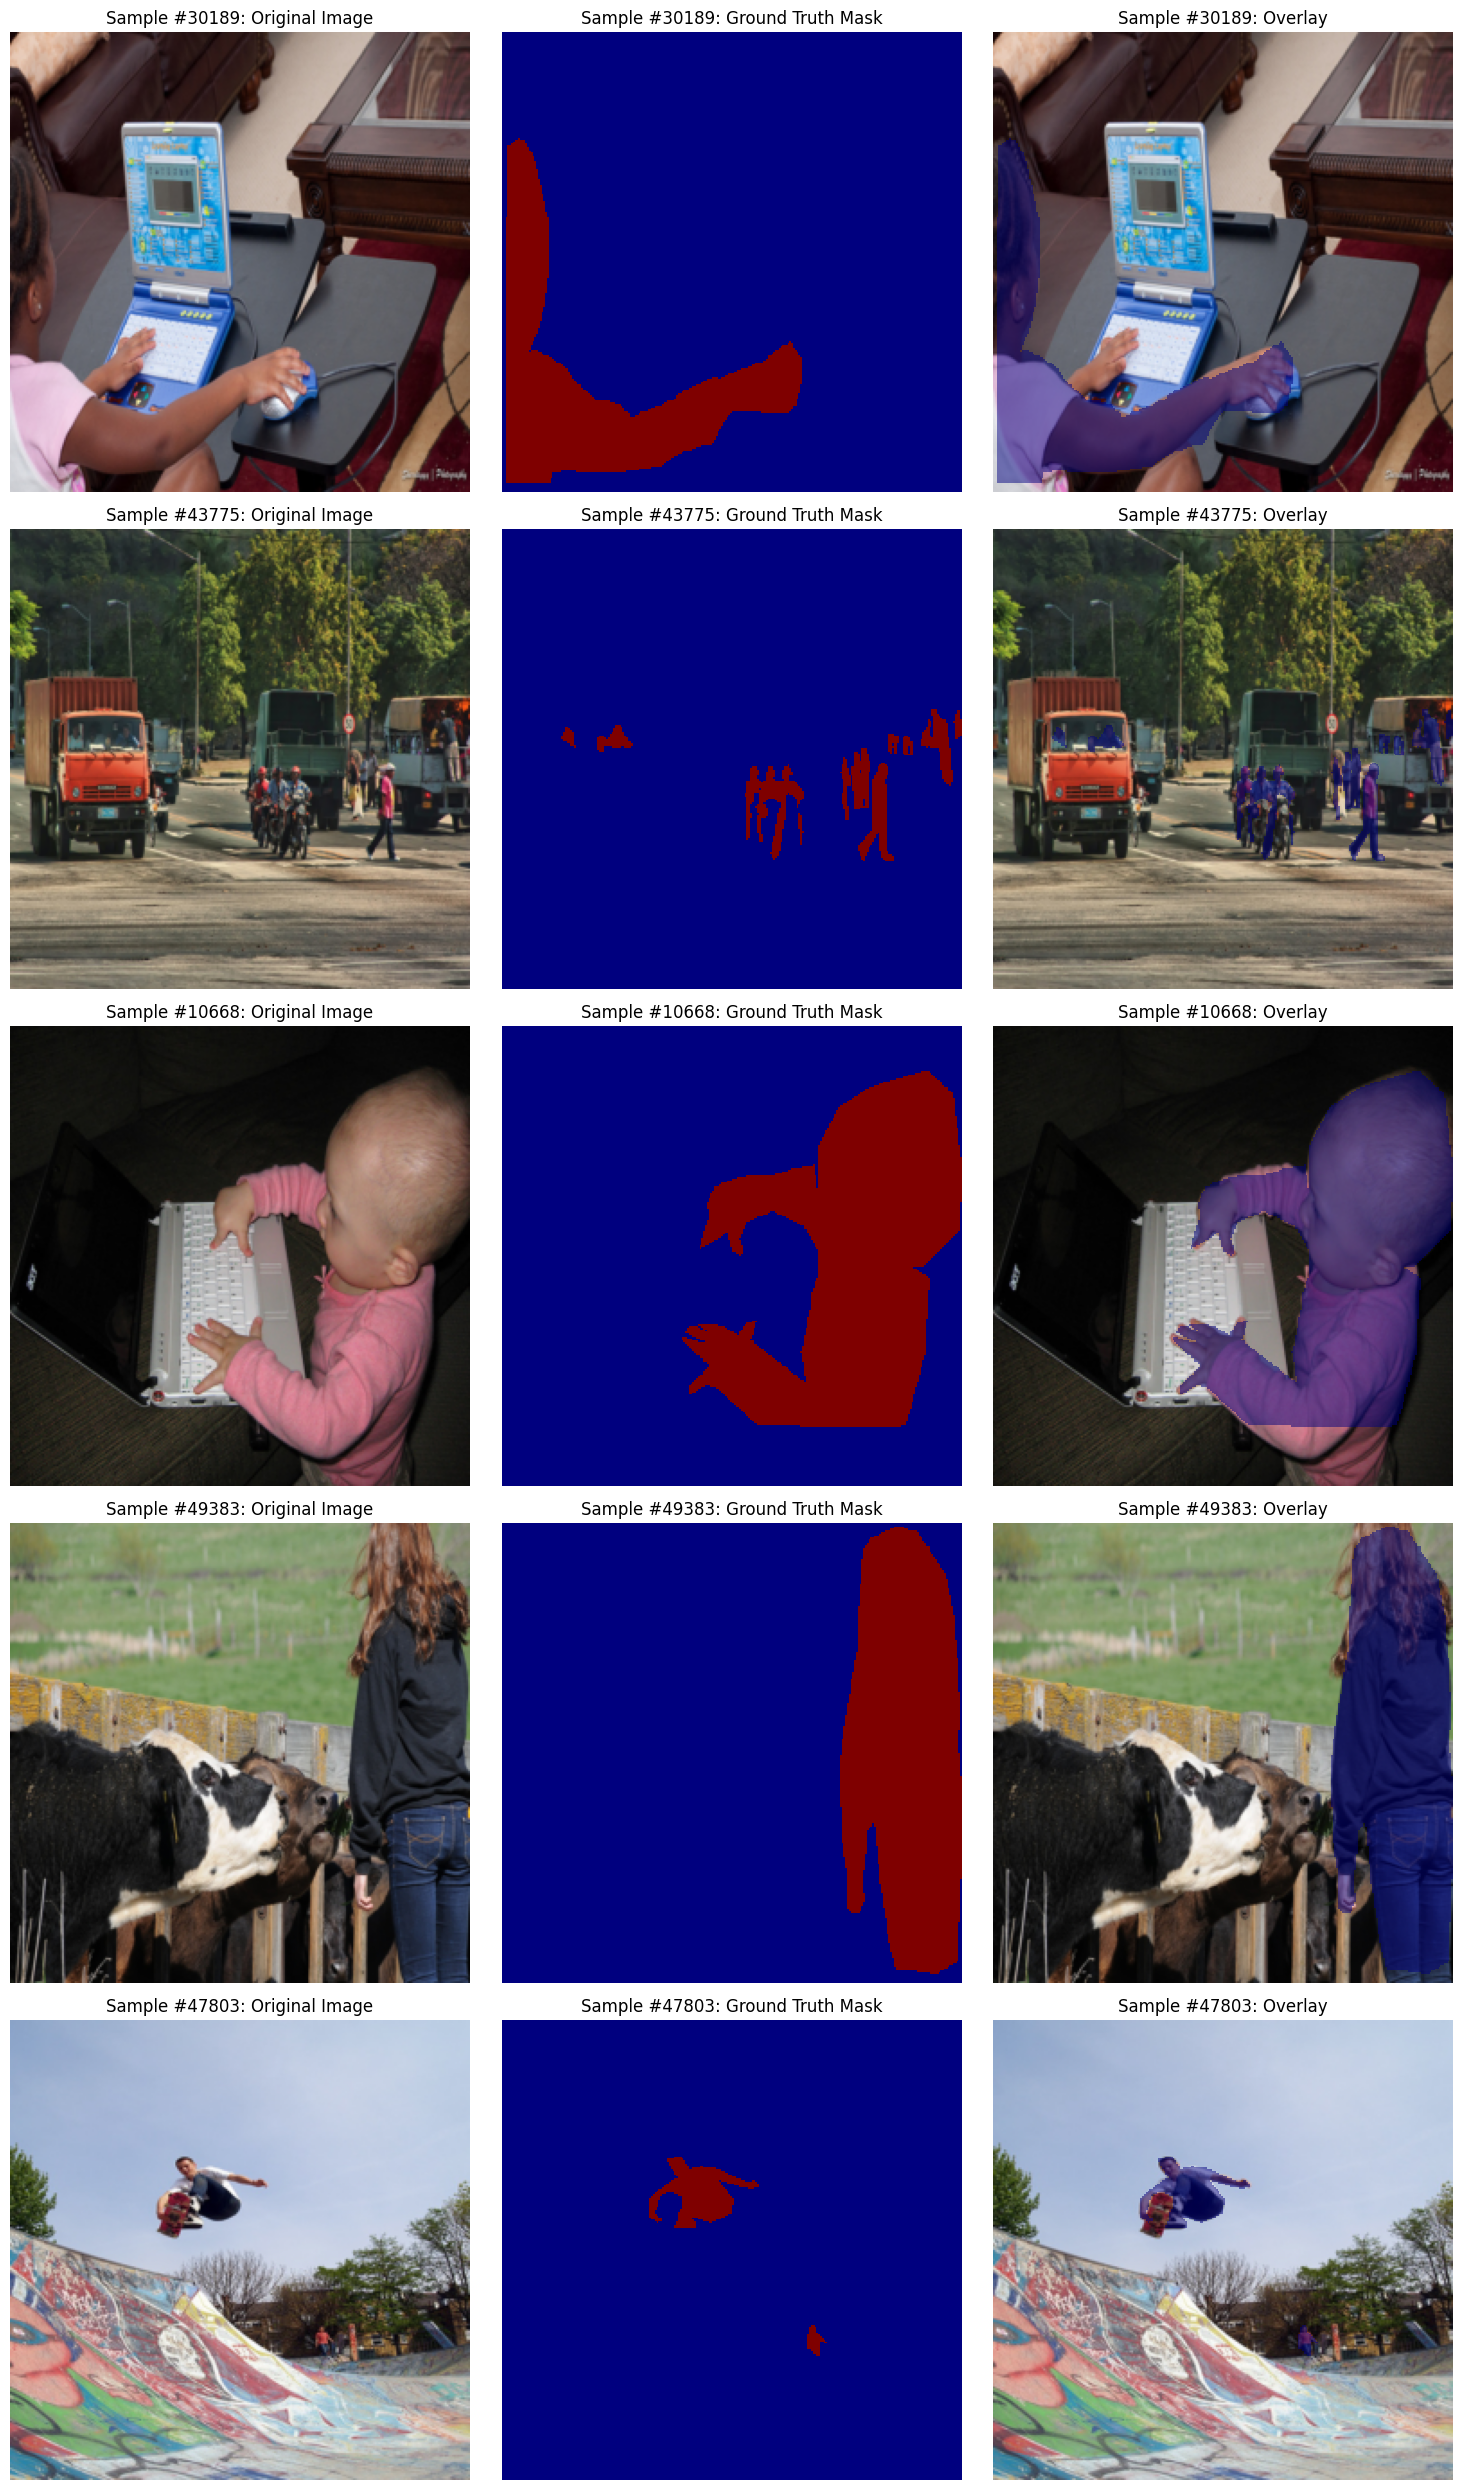

In [2]:
def visualize_random_images(dataset, num_samples=3):
    """
    Picks random samples from the dataset and visualizes:
    1. The original image
    2. The segmentation mask
    3. An overlay of the mask on the image
    """
    
    # 1. Select random indices
    indices = random.sample(range(len(dataset)), num_samples)
    
    # Create a figure with 3 columns (Image, Mask, Overlay) and 'num_samples' rows
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))
    
    # If only one sample, wrap axes in list to make it iterable
    if num_samples == 1:
        axes = [axes]
        
    for i, idx in enumerate(indices):
        image_tensor, mask_tensor = dataset[idx]
        
        # 2. Preprocess for plotting
        # Convert Image Tensor (C, H, W) -> Numpy (H, W, C)
        # We assume the tensor is normalized to [0, 1]
        image_np = image_tensor.permute(1, 2, 0).numpy()
        
        # Convert Mask Tensor -> Numpy
        mask_np = mask_tensor.numpy()
        
        # 3. Plot Original Image
        axes[i][0].imshow(image_np)
        axes[i][0].set_title(f"Sample #{idx}: Original Image")
        axes[i][0].axis('off')
        
        # 4. Plot Segmentation Mask
        # We use a colormap to distinguish classes
        axes[i][1].imshow(mask_np, cmap='jet', interpolation='nearest')
        axes[i][1].set_title(f"Sample #{idx}: Ground Truth Mask")
        axes[i][1].axis('off')
        
        # 5. Plot Overlay
        # Display image first
        axes[i][2].imshow(image_np)
        # Overlay mask with transparency (alpha=0.5)
        # Mask out background (class 0) for better visibility if needed
        masked_overlay = np.ma.masked_where(mask_np == 0, mask_np)
        axes[i][2].imshow(masked_overlay, cmap='jet', interpolation='nearest', alpha=0.5)
        axes[i][2].set_title(f"Sample #{idx}: Overlay")
        axes[i][2].axis('off')

    plt.tight_layout()
    plt.show()

# --- Execution ---
if __name__ == "__main__":
    # Ensure your dataset is initialized from the previous step
    # dataset = COCOSegmentationDataset(...) 
    
    # Run the visualization
    visualize_random_images(dataset, num_samples=5)

In [3]:
class DoubleConv(nn.Module):
    """
    (convolution => [BN] => ReLU) * 2
    The paper describes this repeated application of two 3x3 convolutions[cite: 82].
    """
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            # First 3x3 convolution
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            # Second 3x3 convolution
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """
    Downscaling with maxpool then double conv.
    Corresponds to the contracting path: max pool 2x2 followed by double conv[cite: 82].
    """
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """
    Upscaling then double conv.
    Corresponds to the expansive path: up-convolution, concatenation, and double conv[cite: 84].
    """
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # If bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            # The paper specifically mentions "up-convolution" (Transposed Conv) [cite: 84]
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        
        # Input is CHW. 
        # Although we use padding to keep dimensions the same, slight rounding errors 
        # during pooling might cause 1-pixel differences. This pads x1 to match x2.
        diffY = x2.size(2) - x1.size(2)
        diffX = x2.size(3) - x1.size(3)

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        
        # Concatenation with the feature map from the contracting path (skip connection) [cite: 84]
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    """
    Maps the feature map to the desired number of classes using a 1x1 convolution[cite: 86].
    """
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        # 1. Contracting Path (Encoder)
        # Input -> 64 [cite: 27, 28]
        self.inc = DoubleConv(n_channels, 64)
        # 64 -> 128 [cite: 28]
        self.down1 = Down(64, 128)
        # 128 -> 256 [cite: 29]
        self.down2 = Down(128, 256)
        # 256 -> 512 [cite: 30]
        self.down3 = Down(256, 512)
        
        factor = 2 if bilinear else 1
        # 512 -> 1024 [cite: 31]
        # This is the bottom of the U
        self.down4 = Down(512, 1024 // factor)

        # 2. Expansive Path (Decoder)
        # 1024 -> 512 [cite: 39]
        self.up1 = Up(1024, 512 // factor, bilinear)
        # 512 -> 256 [cite: 32]
        self.up2 = Up(512, 256 // factor, bilinear)
        # 256 -> 128 [cite: 28]
        self.up3 = Up(256, 128 // factor, bilinear)
        # 128 -> 64 [cite: 34]
        self.up4 = Up(128, 64, bilinear)
        
        # 3. Final Output Layer [cite: 86]
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        # Encoder
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        
        # Decoder (with skip connections to encoder features)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        
        logits = self.outc(x)
        return logits

In [4]:
if __name__ == "__main__":
    # Example: 3 channels (RGB), 2 classes (Background + Person)
    # The paper uses stochastic gradient descent (SGD) with momentum 0.99[cite: 90, 93].
    model = UNet(n_channels=3, n_classes=2)
    
    # Move to GPU if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    # Test with a dummy input
    # Batch size 1, 3 channels, 256x256 image
    dummy_input = torch.randn(1, 3, 256, 256).to(device)
    output = model(dummy_input)
    
    print(f"Input shape: {dummy_input.shape}")
    print(f"Output shape: {output.shape}") 
    # Output should be [1, 2, 256, 256] matching the input HxW

Input shape: torch.Size([1, 3, 256, 256])
Output shape: torch.Size([1, 2, 256, 256])


In [5]:
# --- Import your custom modules ---
# Assuming your previous classes are in the same file. 
# If they are in different files, import them like:
# from unet_model import UNet, weights_init
# from dataset_loader import COCOSegmentationDataset, simple_transform
def weights_init(m):
    """
    Paper Section 3: "Gaussian distribution with a standard deviation of sqrt(2/N)"
    This is commonly known as Kaiming/He Initialization.
    """
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    epoch_loss = 0
    
    # tqdm creates a progress bar
    loop = tqdm(loader, leave=True)
    
    for images, masks in loop:
        # 1. Move data to GPU
        images = images.to(device)
        masks = masks.to(device)
        
        # 2. Forward Pass
        predictions = model(images)
        
        # 3. Calculate Loss
        loss = criterion(predictions, masks)
        
        # 4. Backward Pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Update progress bar
        epoch_loss += loss.item()
        loop.set_postfix(loss=loss.item())
        
    return epoch_loss / len(loader)

def main():
    # --- Hyperparameters for RTX 5090 ---
    LEARNING_RATE = 1e-4
    BATCH_SIZE = 32        # Increased for 32GB VRAM
    NUM_EPOCHS = 10
    NUM_CLASSES = 2        # Background + Person
    NUM_WORKERS = 0        # To keep the GPU fed with data
    
    # 1. Setup Device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    if device.type == 'cuda':
        print(f"GPU Name: {torch.cuda.get_device_name(0)}")
        print(f"Memory Usage: {torch.cuda.memory_allocated(0) / 1024**3:.2f} GB")

    # 2. Data Setup
    # Ensure you point to your actual COCO paths here
    data_path = './coco/train2017' 
    ann_path = './coco/annotations/instances_train2017.json'
    
    # Initialize your dataset (Make sure COCOSegmentationDataset is defined above or imported)
    print("Loading dataset...")
    try:
        dataset = COCOSegmentationDataset(
            root_dir=data_path, 
            ann_file=ann_path, 
            transform=simple_transform,
            target_classes=['person']
        )
    except NameError:
        print("Error: COCOSegmentationDataset is not defined. Make sure you run the dataset cell/file first.")
        sys.exit(1)
        
    train_loader = DataLoader(
        dataset, 
        batch_size=BATCH_SIZE, 
        shuffle=True, 
        num_workers=NUM_WORKERS,
        pin_memory=True # Faster data transfer to CUDA
    )
    
    # 3. Model Setup
    print("Initializing Model...")
    model = UNet(n_channels=3, n_classes=NUM_CLASSES).to(device)
    model.apply(weights_init) # Apply He Initialization

    # 4. Loss and Optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    # 5. Training Loop
    print("Starting Training...")
    for epoch in range(NUM_EPOCHS):
        print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
        
        avg_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
        
        print(f"Average Loss: {avg_loss:.4f}")
        
        # Save Checkpoint every epoch
        torch.save(model.state_dict(), f'unet_coco_epoch_{epoch+1}.pth')
        print("Model saved!")

if __name__ == "__main__":
    main()

Using device: cuda
GPU Name: NVIDIA GeForce RTX 5090
Memory Usage: 0.44 GB
Loading dataset...
loading annotations into memory...
Done (t=16.05s)
creating index...
index created!
Initializing Model...
Starting Training...

Epoch 1/10


100%|██████████████████████████████████████████████████████████████████| 2004/2004 [21:02<00:00,  1.59it/s, loss=0.267]


Average Loss: 0.3205
Model saved!

Epoch 2/10


100%|██████████████████████████████████████████████████████████████████| 2004/2004 [13:34<00:00,  2.46it/s, loss=0.414]


Average Loss: 0.2242
Model saved!

Epoch 3/10


100%|██████████████████████████████████████████████████████████████████| 2004/2004 [13:38<00:00,  2.45it/s, loss=0.183]


Average Loss: 0.1902
Model saved!

Epoch 4/10


100%|██████████████████████████████████████████████████████████████████| 2004/2004 [13:35<00:00,  2.46it/s, loss=0.142]


Average Loss: 0.1690
Model saved!

Epoch 5/10


100%|██████████████████████████████████████████████████████████████████| 2004/2004 [13:45<00:00,  2.43it/s, loss=0.137]


Average Loss: 0.1534
Model saved!

Epoch 6/10


100%|██████████████████████████████████████████████████████████████████| 2004/2004 [13:40<00:00,  2.44it/s, loss=0.157]


Average Loss: 0.1415
Model saved!

Epoch 7/10


100%|██████████████████████████████████████████████████████████████████| 2004/2004 [13:47<00:00,  2.42it/s, loss=0.179]


Average Loss: 0.1308
Model saved!

Epoch 8/10


 14%|█████████▌                                                         | 286/2004 [01:58<11:54,  2.40it/s, loss=0.121]


KeyboardInterrupt: 

Loading model from unet_coco_epoch_1.pth...
Model loaded!
Testing on image: 000000384531.jpg


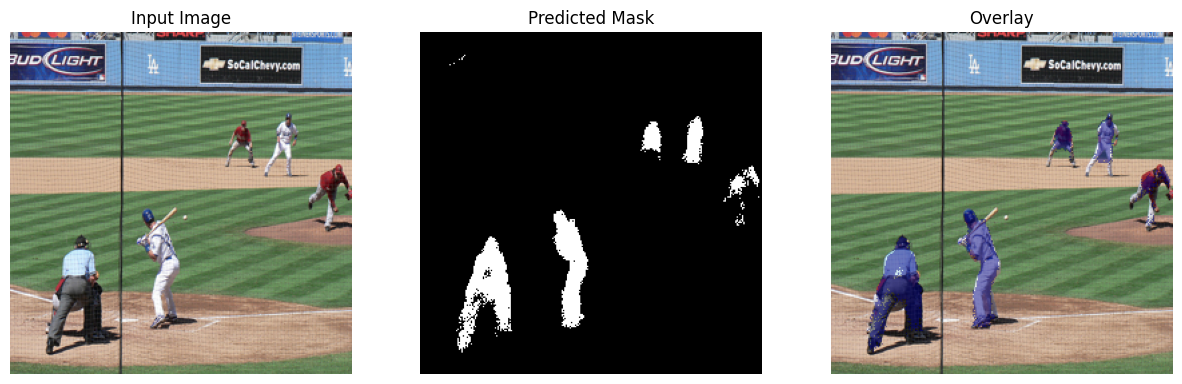

In [10]:
def predict_single_image(model, image_path, device):
    """
    Loads an image, runs it through the model, and returns original + mask.
    """
    model.eval()
    
    # 1. Load Image
    original_pil = Image.open(image_path).convert('RGB')
    
    # 2. Preprocess
    # We create a dummy mask because simple_transform expects two arguments
    w, h = original_pil.size
    dummy_mask = Image.new('L', (w, h))
    
    # Apply the EXACT same transform used during training
    img_tensor, _ = simple_transform(original_pil, dummy_mask)
    
    # Add batch dimension [3, 256, 256] -> [1, 3, 256, 256]
    img_tensor = img_tensor.unsqueeze(0).to(device)
    
    # 3. Inference
    with torch.no_grad():
        output = model(img_tensor)
        
        # Convert logits to probabilities
        probs = torch.softmax(output, dim=1)
        
        # Get the class index with highest probability (0=Background, 1=Person)
        # [1, 2, 256, 256] -> [256, 256]
        pred_mask = torch.argmax(probs, dim=1).cpu().numpy()[0]
        
    # Resize original image to 256x256 for visualization alignment
    original_resized = original_pil.resize((256, 256))
    
    return original_resized, pred_mask

def visualize_prediction(image, mask):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    
    # 1. Original Image
    ax1.imshow(image)
    ax1.set_title("Input Image")
    ax1.axis('off')
    
    # 2. Predicted Mask (Black & White)
    ax2.imshow(mask, cmap='gray')
    ax2.set_title("Predicted Mask")
    ax2.axis('off')
    
    # 3. Overlay (Blue mask on image)
    ax3.imshow(image)
    # Mask out the background (class 0) so we only see the person
    masked_overlay = np.ma.masked_where(mask == 0, mask)
    ax3.imshow(masked_overlay, cmap='jet', alpha=0.5) 
    ax3.set_title("Overlay")
    ax3.axis('off')
    
    plt.show()

def main():
    # --- CONFIG ---
    # Update this to the epoch you want to test (e.g., epoch 1, 5, or 10)
    CHECKPOINT_PATH = 'unet_coco_epoch_1.pth' 
    IMAGE_DIR = './coco/train2017'
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Loading model from {CHECKPOINT_PATH}...")

    # 1. Initialize Model Architecture
    model = UNet(n_channels=3, n_classes=2).to(device)
    
    # 2. Load Weights
    if os.path.exists(CHECKPOINT_PATH):
        model.load_state_dict(torch.load(CHECKPOINT_PATH))
        print("Model loaded!")
    else:
        print(f"Error: Checkpoint '{CHECKPOINT_PATH}' not found.")
        return

    # 3. Pick a random image from the folder
    all_images = os.listdir(IMAGE_DIR)
    random_image_file = random.choice(all_images)
    image_path = os.path.join(IMAGE_DIR, random_image_file)
    
    print(f"Testing on image: {random_image_file}")
    
    # 4. Run Prediction
    img, mask = predict_single_image(model, image_path, device)
    
    # 5. Show
    visualize_prediction(img, mask)

if __name__ == "__main__":
    main()